# Introducción al Deep Learning: fundamentos, arquitecturas y aplicaciones
## David de la Rosa de la Rosa (drrosa@ujaen.es)
## Manuel Germán Morales (mgerman@ujaen.es)

### Redes Neuronales: Introducción a la Inteligencia Artificial y Aprendizaje Profundo

En este cuaderno aprenderemos cómo se programa una Red Neuronal Recurrente con Pytorch Lightning.

### Instalación de librerías necesarias

In [ ]:
!pip install pytorch-lightning tensorboard torchviz --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 60.0 MB/s eta 0:00:00


### Carga del dataset

In [ ]:
import requests # Obtenemos el dataset de la nube
import zipfile
import io
r = requests.get("https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip",  )
zip = zipfile.ZipFile(io.BytesIO(r.content))
zip.extractall()
zip.close()

In [ ]:
import pandas as pd

# Cargo el dataframe
data = pd.read_csv(r'jena_climate_2009_2016.csv')

# Remuestreo la serie para quedarme con una frecuencia horaria.
# Obtengo las observaciones correspondientes al año 2016
data = data[5::6]
data = data[len(data)-8760:] # En python es legal hacer data[-8760:] también.

# Ajusto el índice a la columna con la fecha
data['Date Time'] = pd.to_datetime(data['Date Time'], format="%d.%m.%Y %H:%M:%S")

# Asigno el índice y me quedo con la temperatura
data.set_index("Date Time", inplace=True)
data = data["T (degC)"]
data.head()


,T (degC)
Date Time,
2015-12-29 22:00:00,3.32
2015-12-29 23:00:00,2.98
2015-12-30 00:00:00,1.28
2015-12-30 01:00:00,-0.18
2015-12-30 02:00:00,0.03


In [ ]:
data.describe().T

,T (degC)
count,8760.000000
mean,9.939906
std,8.232126
min,-13.670000
25%,3.550000
50%,9.080000
75%,16.310000
max,34.340000


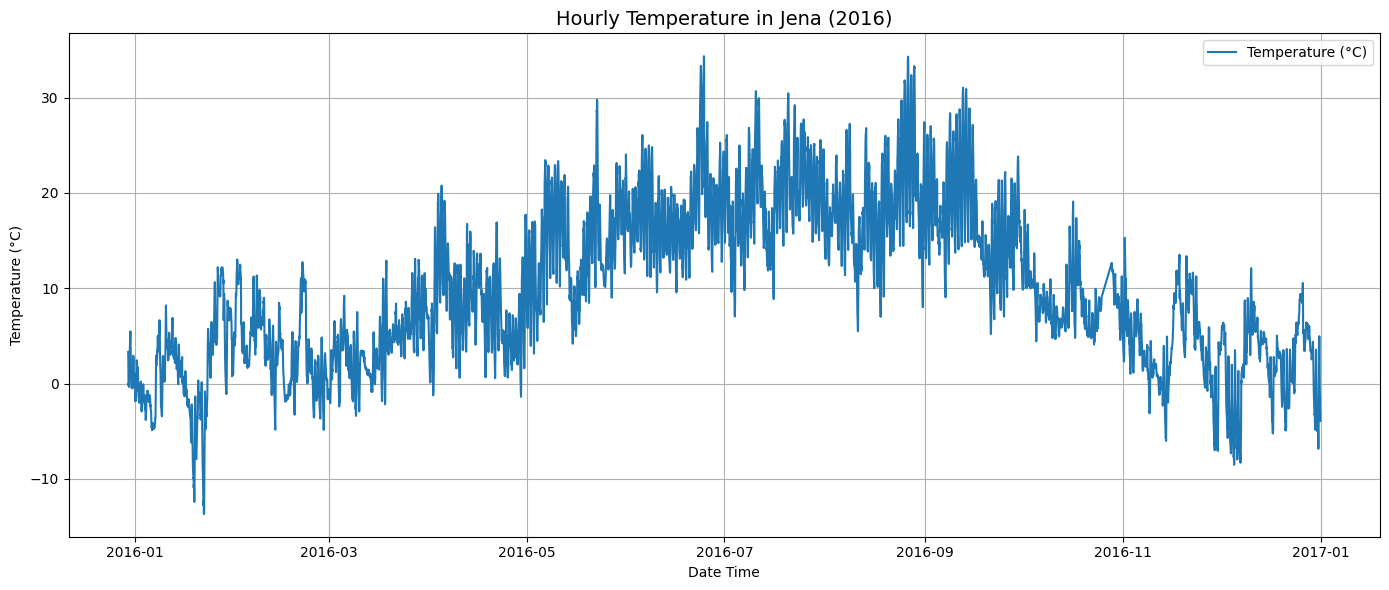

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.plot(data, label='Tempt (°C)', color='tab:blue')
plt.title('Temperatura por hora en Jena (2016)', fontsize=14)
plt.xlabel('Date Time')
plt.ylabel('Tempt (°C)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Particionado del conjunto de datos

Recordemos:
- Conjunto de entrenamiento: Para tomar decisiones de preprocesamiento y optimización de hiperparámetros.
- Conjunto de validación: Para saber cómo se comporta el modelo durante mi entrenamiento.
- Conjunto de test: Para evaluar el modelo con datos que nunca ha visto.

In [ ]:
PROPORCION_TEST = 0.2
PROPORCION_VAL = 0.1
tam_ds = len(data)
tam_test = int(tam_ds * PROPORCION_TEST)
tam_val = int(tam_ds * PROPORCION_VAL)
tam_train = tam_ds - tam_test - tam_val

train_data = data[:tam_train]
val_data = data[tam_train:tam_train+tam_val]
test_data = data[tam_train+tam_val:]

### Creación de las ventanas deslizantes

Para crear las ventanas recorremos la serie instante por instante. La primera ventana contendrá los primeros _past_history_ instantes, que se usarán para predecir los _forecast_horizon_ siguientes y así sucesivamente. A medida que recorremos la serie, iremos desplazando en una observación la ventana. Al final, tendremos un total de ventanas equivalente a _longitud(serie) − past_horizon − forecast_horizon_. Todas estas ventanas se guardan en las listas X e Y, de tal manera que la ventana _i_ almacene sus instantes de entrada
en X y su horizonte esperado en Yusando el mismo índice.

Diagrama sin título.drawio.svg

In [ ]:
from torch.utils.data import Dataset
import numpy as np
import torch
class SlidingWindowDataset(Dataset):
    """
    Parámetros
      - ds: Dataset completo
      - train_size: Proporción a usar como conjunto de entrenamiento
      - past_history: Historial de lags a usar para la predicción
      - forecast_horizon: Horizonte de predicción (número de instantes temporales a predecir)
    """
    def __init__(self, serie, past_history, forecast_horizon, dtype=np.float32) -> None:
        self.past_history = past_history # lags usados para la predicción
        self.forecast_horizon = forecast_horizon # Tamaño del horizonte a predecir

        # Creación de las ventanas
        x, y = [], [] # Conjuntos de entrada y salida (X, Y)
        for i in range(len(serie) - forecast_horizon - past_history):
          x.append(serie[i:i+past_history]) # Obtén los elementos con índices [i, i+past_history)
          y.append(serie[i+past_history:i+past_history+forecast_horizon]) # ídem, para rango [i+past_history, i+past_history+forecast_horizon]

        # Contendrá los instantes que usan como entrada para cada ventana
        self.x = np.array(x)

        # Contendrá los instantes que usan como horizonte a predecir de cada ventana
        self.y = np.array(y)

    # Ídem a sobreescribir el operador << de C++
    def __str__(self) -> str:
        out = f'\nSlidingWindowDataset(past_history={self.past_history}, horizon={self.forecast_horizon})\n'
        out += f'SHAPES:\n\tX shape {self.x.shape}\n\tY shape {self.y.shape}\n'
        return out

    # Necesario para que DataLoader sepa el tamaño del dataset
    def __len__(self):
        return self.x.shape[0]

    # Obtener un elemento del dataset usando el operador corchete [indice]
    def __getitem__(self, index): # Es necesario convertir a tensor para que PyTorch pueda usarlo
        return torch.from_numpy(self.x[index]).reshape((-1, 1)).float(), torch.from_numpy(self.y[index]).reshape((-1, 1)).float()

Establecemos horizonte de predicción y tamaño de la entrada de la ventana.

In [ ]:
PAST_HISTORY = 48
FORECAST_HORION = 24

Creamos los datasets a partir de las particiones.

In [ ]:
train_ds = SlidingWindowDataset(train_data, PAST_HISTORY, FORECAST_HORION)
val_ds = SlidingWindowDataset(val_data, PAST_HISTORY, FORECAST_HORION)
test_ds = SlidingWindowDataset(test_data, PAST_HISTORY, FORECAST_HORION)
print(train_ds)


SlidingWindowDataset(past_history=48, horizon=24)
SHAPES:
	X shape (6060, 48)
	Y shape (6060, 24)



In [ ]:
print(val_ds)


SlidingWindowDataset(past_history=48, horizon=24)
SHAPES:
	X shape (804, 48)
	Y shape (804, 24)



In [ ]:
print(test_ds)


SlidingWindowDataset(past_history=48, horizon=24)
SHAPES:
	X shape (1680, 48)
	Y shape (1680, 24)



Recordemos que la clase `Dataloader` permite definir el orden y la forma de cargar los datos de cara al entrenamiento, validación y test. En su constructor podemos determinar el conjunto de datos a cargar, el tamaño de los lotes que se desean formar y si se quieren mezclar o no las instancias devueltas por el conjunto de datos a gestionar.

Como nuestras instancias se corresponde con ventanas que sí respentan el orden temporal de los lags que guardan, podemos indicar el mezclado de ellas en el `Dataloader` para que nuestro modelo generalice mejor. Sin embargo, nosotros no mezclaremos las instancias.

In [ ]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=64, shuffle=False) # IMPORTANTE NO MEZCLAR
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

**[EJERCICIO]** ¿Por qué no podemos mezclar las instancias?

### Construyendo la red recurrente

Como sabemos, una red recurrente es capaz de mantener un estado (estado oculto, `h`), el cual contendrá información relevante sobre los distintos pasos de la serie que procesa. Este estado actua como una memoria y se actualiza secuencialmente, lo que impide la paralelización de este tipo de redes. Con secuencias suficientemente largas, se puede producir un desvanecimiento o explosión del gradiente además de la pérdida de información inicial en el estado oculto. Existen varios tipos de céldas (o células, o _neuronas_) recurrentes que intentan solucionar estos problemas.

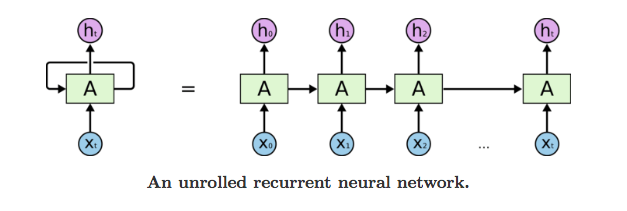

Para implementar las capas recurrentes, usaremos los módulos `nn.RNN`, `nn.LSTM` o `nn.GRU`. La especificación de los siguientes atributos es fundamental para la construcción de la capa:
* `input_size`: Número de **características** presentes en cada paso temporal de la secuencia de entrada. En nuestro caso es 1.
* `hidden_size`: Tamaño del estado oculto de una celda.
* `dropout`: Indicar qué porcentaje de celdas queremos desactivar en el entrenamiento de manera aleatoria.
* `batch_first`: Si la dimensión que recoge el número de instancias que forman el lote va primera o última. Si su valor es `True`, el tensor de entrada debe de tener la forma `(BATCH_SIZE, LEN, FEATURES)`. Si no, se espera `(LEN, BATCH_SIZE, FEATURES)`.

Existen otros atributos que podemos especificar en la documentación de Pytorch.
Probemos previamente una de estas capas y veamos sus entradas y salidas. Usaremos un lote de ejemplo extraido del dataloader anterior.

In [ ]:
batch = next(iter(train_dl))
X_batch, Y_batch = batch
print(X_batch.shape)
print(Y_batch.shape)

torch.Size([64, 48, 1])
torch.Size([64, 24, 1])


En este caso, `input_size` equivale a 1. Usaremos un tamaño oculto de 30 y un número de capas igual a 1. Especificaremos que la dimensión que indica el tamaño del lote es la primera.

El módulo `LSTM` devuelve tres tensores. El primero de ellos (`output`) contiene todos los estados ocultos para cada instante de cada secuencia del lote de la última capa de la red. La tupla `(hn, cn)` recoge el estado oculto y de la celda que sale en cada capa de la red para cada secuencia del lote. La siguiente ilustración muestra mejor el valor que toman estos tensores. Los módulos `RNN` y `GRU` poseen un comportamiento similar, pero devuelviendo únicamente un elemento en la tupla anterior (ya que solo poseen un estado oculto).

In [ ]:
import torch.nn as nn
lstm = nn.LSTM(input_size=X_batch.shape[2], hidden_size=30, num_layers=1, batch_first=True)
output, (hn, cn) = lstm(X_batch)
print(f'Output: {output.shape}')
print(f'hn: {hn.shape}')
print(f'cn: {cn.shape}')

Output: torch.Size([64, 48, 30])
hn: torch.Size([1, 64, 30])
cn: torch.Size([1, 64, 30])


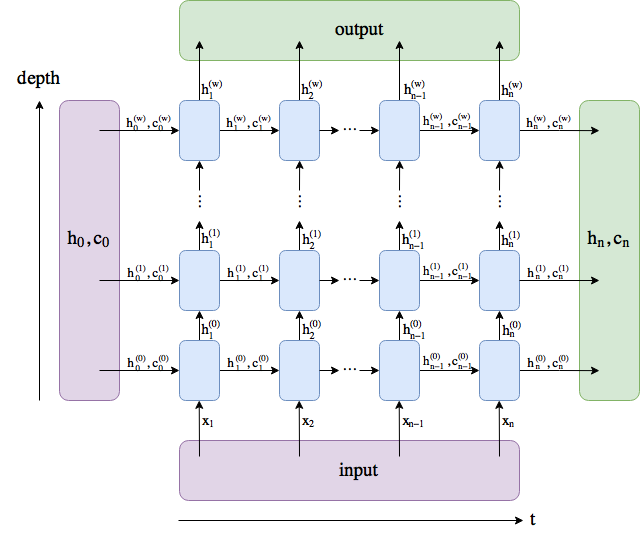

Empezaremos creando un módulo de Pytorch, encargado de construir y guardar la lógica del modelo. Usaremos celdas básicas `RNN`. En su constructor, aceptará los siguientes parámetros:
* `num_rnn_layers`: Número de capas recurrentes del modelo.
* `hidden_dim`: Tamaño del estado oculto de una capa recurrente.
* `input_sizes`: Número de características de entrada que posee cada paso (lag) de la secuencia a procesar.
* `output_len`: Longitud de la secuencia a predecir.

In [ ]:
class MIMORNNModel(nn.Module):
    def __init__(self, num_rnn_layers: int = 1, hidden_dim: int = 30, input_size: int = 1, output_len: int = 1) -> None:
        # Inicializo mi clase padre
        super(MIMORNNModel, self).__init__()


        # Construyo la arquitectura en función de mis hiperparámetros
        # Creo la primera capa: Características de entrada = características de un paso temporal
        # Características de salida: Longitud del estado oculto.
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_dim, dropout=0, num_layers=num_rnn_layers, batch_first=True)


        # El número de características de entreada se corresponderá con el tamaño de la dimensión oculta de cada capa
        # Capa densa (o lineal) para realizar la predicción
        self.linear = nn.Linear(in_features=hidden_dim, out_features=output_len)


    # En el método forward, defino cómo interactuan los diferentes componentes del modelo
    # Método forward: Paso hacia adelante, realizar predicciones
    #   x_in: Tensor de entrada
    #   state: En caso de querer inicializar los estados ocultos de la red a un valor
    def forward(self, x_in, state=None):
        # Procesar la entrada en la primera capa en función del tensor de salida y
        # del estado que se use para su inicialización. Las salidas de una capa recurrente son:
        # h: Tensor de dimensiones (lote, longitud secuencia, hidden_dim). Salida de la capa para cada secuencia del lote
        # (h_n): Conatenación del último estado oculto de cada capa. Como procesamos las capas nosotros, h_t = h[-1]
        h, h_n = self.rnn(x_in, state) if state is not None else self.rnn(x_in)

        # Uso solo el último estado oculto del modelo
        h = h[:, -1, :] # Solo la última salida del modelo

        f_out = self.linear(h) # Aplicamo la capa lineal
        # Como la entrada posee la forma (BS, LEN, CARACTERISTICAS), ajustamos la salida para
        # que de también esta forma. Como predecimos una única característica, la forma de f_out
        # es (BS, LEN). Explicitamos la existencia de esa característica añadiendo una nueva dimensión
        # de tamaño 1: (BS, LEN, 1)
        # [[A, B]] -> [[[A], [B]]]
        f_out = torch.unsqueeze(f_out, dim=-1)

        # Devuelvo el resultado
        return f_out, state


La siguiente clase recoge los hiperparámetros relacionados con el entrenamiento además de las funciones necesarias para que un entrenador (`Trainer`) de Lightning pueda entrenar nuestro modelo.

In [ ]:
import torchmetrics
import pytorch_lightning as pl
from torch import optim
class MIMORNN(pl.LightningModule):
  # Hiperparámetros del modelo y del entrenamiento
    def __init__(self, num_rnn_layers: int = 1, hidden_dim: int = 30, input_size: int = 1, input_len: int = 1, output_len: int = 1, lr: float = 0.001) -> None:
        super().__init__()

        # Modelo anterior
        self.model = MIMORNNModel(num_rnn_layers, hidden_dim, input_size, output_len)

        # Ratio de aprendizaje del optimizador
        self.lr = lr

        # Función de pérdida
        self.loss = nn.L1Loss()

        # Horizonte de predicción y tamaño de la entrada
        self.horizonte = output_len
        self.input_len = input_len

        # Contador de épocas
        self.epoch = 0

        # Identificador del modelo
        self.model_name = "RNN"

        # Registro de la pérdida (loss) por batch y época
        self.train_loss = []
        self.val_loss = []
        self.epoch_train_loss = []
        self.epoch_val_loss = []

        # Métricas
        self.rmse = torchmetrics.MeanSquaredError(squared=False)
        self.mse = torchmetrics.MeanSquaredError(squared=True)
        self.smape = torchmetrics.MeanAbsolutePercentageError()

    # ====== ENTRENAMIENTO =======
    # Al inicio del entrenamiento, limpiar las listas que guardan la pérdida por batch
    def on_train_start(self) -> None:
        self.epoch_train_loss.clear()
        self.train_loss.clear()
        self.epoch_train_loss.clear()
        self.epoch_val_loss.clear()
        return super().on_train_start()

    # Al finalizar cada época del entrenamiento, calcular la pérdida media y registrarla en Tensorboard
    # Registrar también en una misma gráfica la pérdida de entrenamiento y validación
    def on_train_epoch_end(self) -> None:
        epoch_loss = sum(self.train_loss)/len(self.train_loss)
        self.epoch_train_loss.append(epoch_loss)
        self.train_loss.clear()
        self.log_dict({"epoch_train_loss": epoch_loss, "step": self.epoch})
        self.logger.experiment.add_scalars('epoch_loss', {'train': epoch_loss, 'val': self.epoch_val_loss[self.epoch]}, global_step=self.epoch)
        self.epoch+=1
        return super().on_train_epoch_end()

    # Paso de entrenamiento.
    def training_step(self, batch, batch_idx):
        x, y = batch # Obtener la entrada y etiquetas del batch suministrado por el dataloader
        pred, state = self.model(x) # Realizo la predicción
        loss = self.loss(pred, y) # Calculo la pérdida y la registro
        self.train_loss.append(loss.cpu().detach().numpy())
        return loss

    # ====== VALIDACIÓN =======
    # Al finalizar una época de validación, calcular su pérdida media, guardarla y registrarla
    # en TensorBoard
    def on_validation_epoch_end(self) -> None:
        epoch_loss = sum(self.val_loss)/len(self.val_loss)
        self.epoch_val_loss.append(epoch_loss)
        self.val_loss.clear()
        self.log_dict({"epoch_val_loss": epoch_loss, "step": self.epoch})
        return super().on_validation_epoch_end()

    # Paso de validación. Similar al de entrenamiento.
    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred, state = self.model(x)
        loss = self.loss(pred, y)
        self.val_loss.append(loss.cpu().detach().numpy())
        return loss

    # ====== TEST =======
    # Paso de predicción (test).
    def test_step(self, batch, batch_idx):
        x, y = batch # Obtenemos la entrada y las etiquetas esperadas
        pred, state = self.model(x)
        self.rmse(pred, y) # Calculamos el RMSE y MSE usando torchmetrics
        self.mse(pred, y)
        self.smape(pred, y)
        loss = self.loss(pred, y) # También calculamos la pérdida
        # Registramos las métricas calculadas.
        self.log_dict({'test_rmse': self.rmse, 'test_mse': self.mse, 'test_loss': loss, 'test_smape': self.smape})

    # ===== CONFIGURACIÓN DEL MODELO =====
    # Optimizador a usar
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

Creamos nuestro modelo y lo entrenamos

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/

In [ ]:
rnn = MIMORNN(num_rnn_layers=3, hidden_dim=128, input_size=1, input_len=PAST_HISTORY, output_len=FORECAST_HORION, lr=0.0001) # Creación de una red neuronal recurrente con celdas LSTM
print(rnn)
trainer = pl.Trainer(log_every_n_steps=1, max_epochs=100)
trainer.fit(rnn, train_dataloaders=train_dl, val_dataloaders=val_dl)

MIMORNN(
  (model): MIMORNNModel(
    (rnn): RNN(1, 128, num_layers=3, batch_first=True)
    (linear): Linear(in_features=128, out_features=24, bias=True)
  )
  (loss): L1Loss()
  (rmse): MeanSquaredError()
  (mse): MeanSquaredError()
  (smape): MeanAbsolutePercentageError()
)


Ahora, lo evaluámos con el conjunto de test.

In [ ]:
res = trainer.test(rnn, test_dl, verbose=True)
res

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     2.453542947769165     │
│         test_mse          │     9.777052879333496     │
│         test_rmse         │    3.1268279552459717     │
│        test_smape         │     967.7642822265625     │
└───────────────────────────┴───────────────────────────┘

[{'test_rmse': 3.1268279552459717,
  'test_mse': 9.777052879333496,
  'test_loss': 2.453542947769165,
  'test_smape': 967.7642822265625}]

[**EJERCICIO**] Sabiendo que el RMSE y MSE son métricas absolutas y el SMAPE es una métrica relativa. ¿Qué puedes decir del modelo? ¿Por qué es importante dar ambos tipos de métrica?

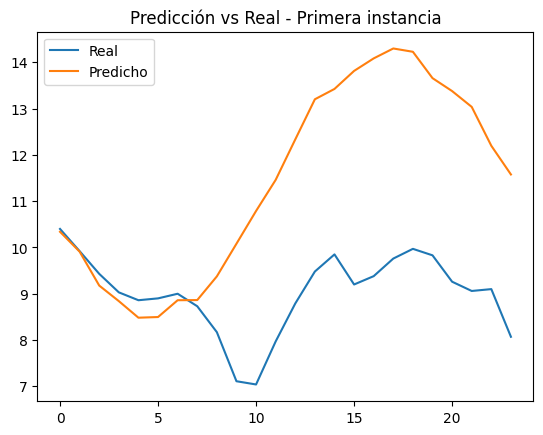

In [ ]:
X_batch, Y_batch = next(iter(test_dl))
preds, _ = rnn.model(X_batch)

plt.plot(Y_batch[0].squeeze().cpu(), label='Real')
plt.plot(preds[0].detach().squeeze().cpu(), label='Predicho')
plt.title("Predicción vs Real - Primera instancia")
plt.legend()
plt.show()

**[EJERCICIO]** El rendimiento del modelo anteriormente implementado se puede mejorar de diversas formas. Plantea e implementa cómo lo mejorarías desde:
  - El preprocesamiento del conjunto de datos.
  - La celda recurrente usada.
  - La información usada como entrada en la capa lineal, encargada de emitir las predicciones.
  - Los hiperparámetros usados en el modelo. ¿Cómo los optimizarías? ¿Qué papel desempeña el estado oculto de la celda recurrente?
  - ¿Cómo se determina el valor del horizonte de predicción y del tamaño de la entrada?
  - Investiga sobre técnicas para inicializar los pesos de una red neuronal. En concreto, investiga sobre las diferentes distribuciones de probabilidad que se pueden usar para ello. ¿Qué caracteriza la inicialización _Xavier_ o _Glorot_? ¿Por qué es interesante en RNN?